In [64]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [65]:
import numpy as np 
import pandas as pd
from pathlib import Path
import re, glob
import matplotlib.pyplot as plt
import seaborn as sns



In [5]:
ipop = np.load("results_bbob_d10_seed0.npz")

In [6]:
df = pd.DataFrame({
    "func_id": ipop.files,
    "ipop_best": [ipop[k] for k in ipop.files],
})

In [12]:
df.head()

,func_id,ipop_best
0,bbob_f001_i01_d10,79.48000228201816
1,bbob_f001_i02_d10,394.4800179518461
2,bbob_f001_i03_d10,-247.10994077724075
3,bbob_f001_i04_d10,-152.0399869581985
4,bbob_f001_i05_d10,-25.249992255834595


In [9]:
# 1) średnia i mediana najlepszych wartości
print(df[["ipop_best"]].describe())

                 ipop_best
count                  360
unique                 360
top     101.39518595381145
freq                     1


In [11]:
# 2) ile funkcji zeszło poniżej progu 1e-8 ?
th = 1e-8
succ_ipop = (df["ipop_best"] < th).sum()
print(f"Sukces IPOP  = {succ_ipop}/{len(df)}")


Sukces IPOP  = 149/360


## Testing

In [24]:
def _last_delta_f(dat_file: Path) -> float:
    """Zwraca ostatnią kolumnę Δf z pliku .dat (ostatni wiersz nie-komentarz)."""
    data = np.loadtxt(dat_file, comments='#')
    return float(data[-1, 1])     # kol. 0 = FEvals, kol. 1 = Δf

def gather_results(root: str | Path) -> pd.DataFrame:
    """
    Zwraca DataFrame z kolumnami:
    dim, seed, alg, func_id, delta_f
    """
    rows = []
    for dim_dir in Path(root).glob('d*'):
        dim = int(dim_dir.name.lstrip('d'))
        for seed_dir in dim_dir.glob('seed*-000[12]'):
            seed, run = re.match(r'seed(\d+)-000(\d)', seed_dir.name).groups()
            alg = 'ipop' if run == '1' else 'cma'
            for dat in seed_dir.glob('**/IOHprofiler_f*_*.dat'):
                func_id = re.search(r'f(\d{3})', dat.name).group(1)
                rows.append(
                    dict(dim=dim,
                         seed=int(seed),
                         alg=alg,
                         func_id=f'F{func_id}',
                         delta_f=_last_delta_f(dat))
                )
    return pd.DataFrame(rows)

def summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    """Średnia i odchylenie std Δf dla każdej kombinacji (alg, dim)."""
    return (df.groupby(['alg', 'dim'])['delta_f']
              .agg(['mean', 'std', 'median'])
              .reset_index())

In [17]:
ROOT = "exdata/bbob_results"

In [23]:
df = gather_results(ROOT)

In [21]:
display(df.head())
print(f"Liczba wierszy: {len(df)}")

""


Liczba wierszy: 0


## Pobieranie npz

In [40]:
data = np.load("npz/cma_bbob_d10_seed0.npz")

In [41]:
print(data.files) 

['bbob_f001_i01_d10', 'bbob_f001_i02_d10', 'bbob_f001_i03_d10', 'bbob_f001_i04_d10', 'bbob_f001_i05_d10', 'bbob_f001_i71_d10', 'bbob_f001_i72_d10', 'bbob_f001_i73_d10', 'bbob_f001_i74_d10', 'bbob_f001_i75_d10', 'bbob_f001_i76_d10', 'bbob_f001_i77_d10', 'bbob_f001_i78_d10', 'bbob_f001_i79_d10', 'bbob_f001_i80_d10', 'bbob_f002_i01_d10', 'bbob_f002_i02_d10', 'bbob_f002_i03_d10', 'bbob_f002_i04_d10', 'bbob_f002_i05_d10', 'bbob_f002_i71_d10', 'bbob_f002_i72_d10', 'bbob_f002_i73_d10', 'bbob_f002_i74_d10', 'bbob_f002_i75_d10', 'bbob_f002_i76_d10', 'bbob_f002_i77_d10', 'bbob_f002_i78_d10', 'bbob_f002_i79_d10', 'bbob_f002_i80_d10', 'bbob_f003_i01_d10', 'bbob_f003_i02_d10', 'bbob_f003_i03_d10', 'bbob_f003_i04_d10', 'bbob_f003_i05_d10', 'bbob_f003_i71_d10', 'bbob_f003_i72_d10', 'bbob_f003_i73_d10', 'bbob_f003_i74_d10', 'bbob_f003_i75_d10', 'bbob_f003_i76_d10', 'bbob_f003_i77_d10', 'bbob_f003_i78_d10', 'bbob_f003_i79_d10', 'bbob_f003_i80_d10', 'bbob_f004_i01_d10', 'bbob_f004_i02_d10', 'bbob_f004_i

In [44]:
best_f_f001 = data["bbob_f001_i03_d10"]
print(f"Najlepsze f(x) na F1: {best_f_f001}")

Najlepsze f(x) na F1: -247.10998932595655


In [35]:
data = None

In [45]:
def load_all_results(npz_folder: str = "npz") -> pd.DataFrame:
    records = []
    for file in Path(npz_folder).glob("*.npz"):
        match = re.match(r"(ipop|cma)_bbob_d(\d+)_seed(\d+)\.npz", file.name)
        if not match:
            continue
        alg, dim, seed = match.group(1), int(match.group(2)), int(match.group(3))

        npz = np.load(file)
        for func_id in npz.files:
            best_f = float(npz[func_id])
            records.append({
                "alg": alg,
                "dim": dim,
                "seed": seed,
                "func_id": func_id,
                "best_f": best_f
            })

    df = pd.DataFrame(records)
    return df

In [46]:
df_results = load_all_results("npz")

In [54]:
df_wide = df_results.pivot_table(
    index=["dim", "seed", "func_id"],
    columns="alg",
    values="best_f"
).reset_index()

In [56]:
df_wide["who_better"] = np.where(
    df_wide["ipop"] < df_wide["cma"], "ipop",
    np.where(df_wide["ipop"] > df_wide["cma"], "cma", "equal")
)

In [58]:
df_wide.head()

alg,dim,seed,func_id,cma,ipop,who_better
0,5,0,bbob_f001_i01_d05,79.480000,79.480000,ipop
1,5,0,bbob_f001_i02_d05,394.480045,394.480000,ipop
2,5,0,bbob_f001_i03_d05,-247.109996,-247.110000,ipop
3,5,0,bbob_f001_i04_d05,-152.039997,-152.040000,ipop
4,5,0,bbob_f001_i05_d05,-25.249990,-25.249995,ipop


In [60]:
counts = (
    df_wide.groupby(["dim", "who_better"])
    .size()
    .reset_index(name="count")
)

,dim,who_better,count
0,5,cma,2284
1,5,equal,153
2,5,ipop,1163
3,10,cma,1790
4,10,equal,150


who_better
cma      5610
ipop     4737
equal     453
Name: count, dtype: int64

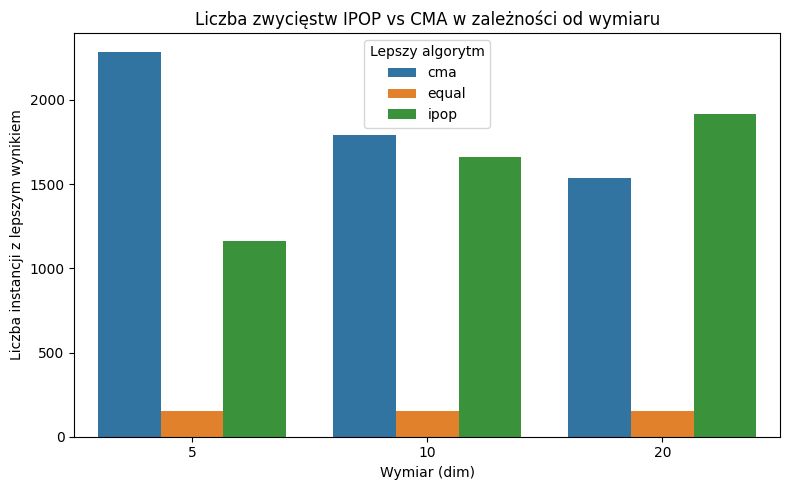

In [66]:
plt.figure(figsize=(8,5))
sns.barplot(data=counts, x="dim", y="count", hue="who_better")
plt.title("Liczba zwycięstw IPOP vs CMA w zależności od wymiaru")
plt.ylabel("Liczba instancji z lepszym wynikiem")
plt.xlabel("Wymiar (dim)")
plt.legend(title="Lepszy algorytm")
plt.tight_layout()
plt.show()

In [67]:
grouped_std = (
    df_results
    .groupby(["alg", "dim", "func_id"])["best_f"]
    .std()
    .reset_index(name="std_dev_per_func")
)

In [68]:
summary_std = (
    grouped_std
    .groupby(["alg", "dim"])["std_dev_per_func"]
    .mean()
    .reset_index(name="avg_std_dev")
)


In [69]:
summary_std.head()

,alg,dim,avg_std_dev
0,cma,5,16.108271
1,cma,10,71.580548
2,cma,20,267.169832
3,ipop,5,312.703083
4,ipop,10,386.174076


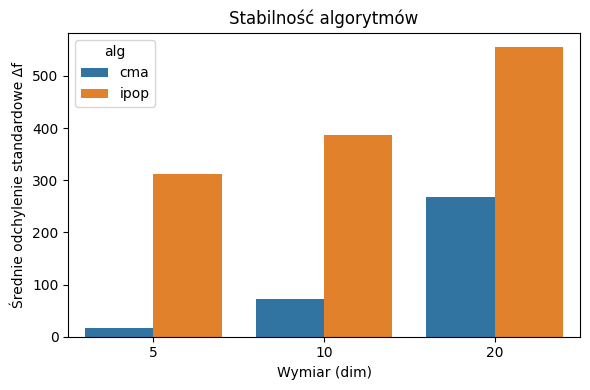

In [74]:
plt.figure(figsize=(6,4))
sns.barplot(data=summary_std, x="dim", y="avg_std_dev", hue="alg")
plt.ylabel("Średnie odchylenie standardowe Δf")
plt.xlabel("Wymiar (dim)")
plt.title("Stabilność algorytmów")
plt.tight_layout()
plt.show()

In [75]:
# 1. Grupujemy średnie dla każdej funkcji i algorytmu
mean_per_func = (
    df_results
    .groupby(["func_id", "alg"])["best_f"]
    .mean()
    .reset_index()
    .pivot(index="func_id", columns="alg", values="best_f")
    .reset_index()
)

# 2. Obliczamy kto lepszy i różnicę
mean_per_func["better"] = np.where(
    mean_per_func["ipop"] < mean_per_func["cma"], "ipop",
    np.where(mean_per_func["ipop"] > mean_per_func["cma"], "cma", "equal")
)

mean_per_func["abs_diff"] = (mean_per_func["cma"] - mean_per_func["ipop"]).abs()
mean_per_func["log10_ratio"] = np.log10(mean_per_func["cma"] / mean_per_func["ipop"])

# 3. Podgląd wyników
mean_per_func_sorted = mean_per_func.sort_values("func_id")
display(mean_per_func_sorted)

c:\Users\kacpe\OneDrive\Pulpit\Uczelnia\Magisterskie\Ewolucyjne\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


alg,func_id,cma,ipop,better,abs_diff,log10_ratio
0,bbob_f001_i01_d05,79.480004,79.480001,ipop,0.000003,1.747166e-08
1,bbob_f001_i01_d10,79.480012,79.480000,ipop,0.000012,6.667649e-08
2,bbob_f001_i01_d20,79.480010,79.480000,ipop,0.000010,5.348719e-08
3,bbob_f001_i02_d05,394.480021,394.480004,ipop,0.000017,1.882335e-08
4,bbob_f001_i02_d10,394.480051,394.480000,ipop,0.000051,5.662778e-08
...,...,...,...,...,...,...
1075,bbob_f024_i79_d10,-942.004995,-962.628165,ipop,20.623170,-9.405358e-03
1076,bbob_f024_i79_d20,-860.730254,-882.870586,ipop,22.140331,-1.102998e-02
1077,bbob_f024_i80_d05,64.596076,66.608375,cma,2.012299,-1.332270e-02
1078,bbob_f024_i80_d10,105.803971,86.331102,ipop,19.472869,8.833468e-02


In [76]:
mean_per_func["better"].value_counts()

better
cma      648
ipop     387
equal     45
Name: count, dtype: int64

In [78]:
# Lista unikalnych funkcji
funcs = df_wide["func_id"].unique()
funcs.sort()

In [ ]:
# Tworzymy 24 osobne wykresy
ncols = 4
nrows = int(np.ceil(len(funcs) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), sharey=True)

for i, func in enumerate(funcs):
    ax = axes[i // ncols, i % ncols]
    subset = df_wide[df_wide["func_id"] == func]
    counts = (
        subset.groupby(["dim", "who_better"])
        .size()
        .reset_index(name="count")
    )
    sns.barplot(data=counts, x="dim", y="count", hue="who_better", ax=ax)
    ax.set_title(func.replace("bbob_", ""))
    ax.set_xlabel("dim")
    ax.set_ylabel("Liczba wygranych")
    ax.legend().set_title("lepszy alg.")

# Usunięcie pustych subplots
for j in range(i+1, ncols*nrows):
    fig.delaxes(axes[j // ncols, j % ncols])

plt.suptitle("Porównanie IPOP vs CMA dla każdej funkcji benchmarkowej", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()